In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy.signal import resample, lfilter
from scipy.interpolate import interp1d
from scipy.signal import freqz

In [ ]:
def mean_squared_error(original, reconstructed):
    """Calculates the Mean Squared Error between two signals."""
    # Ensure signals are of the same length for comparison
    min_len = min(len(original), len(reconstructed))
    return np.mean((original[:min_len] - reconstructed[:min_len])**2)

In [ ]:
def get_audio_file_path():
    """Prompts the user for a WAV file path and validates it."""
    while True:
        # Prompt the user to enter the path to their audio file.
        file_path = input("Please enter the full path to your .wav audio file: ")

        # Check if the file exists and if it is a .wav file.
        if os.path.exists(file_path) and file_path.lower().endswith('.wav'):
            print(f"Successfully located the audio file: {file_path}\n")
            return file_path
        else:
            print("\nError: File not found at that path or it is not a .wav file.")
            # Give the user an option to quit or try again.
            choice = input("Press 'q' to quit, or any other key to try again: ")
            if choice.lower() == 'q':
                return None

In [ ]:
# 1. Get the audio file path from the user first.
speech_file_path = get_audio_file_path()

Please enter the full path to your .wav audio file: /content/mixkit-glitch-radio-vocals-1026.wav
Successfully located the audio file: /content/mixkit-glitch-radio-vocals-1026.wav




--- Running Speech Question 1: Sampling and Reconstruction ---


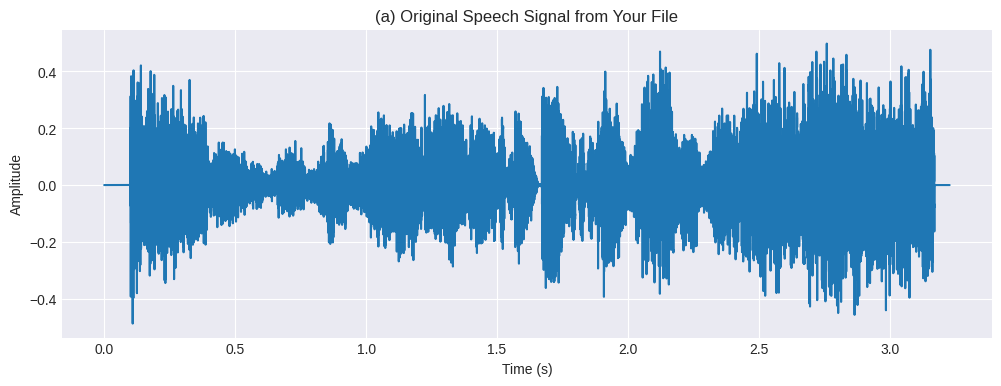


(b, c) Resampling speech signal and plotting:


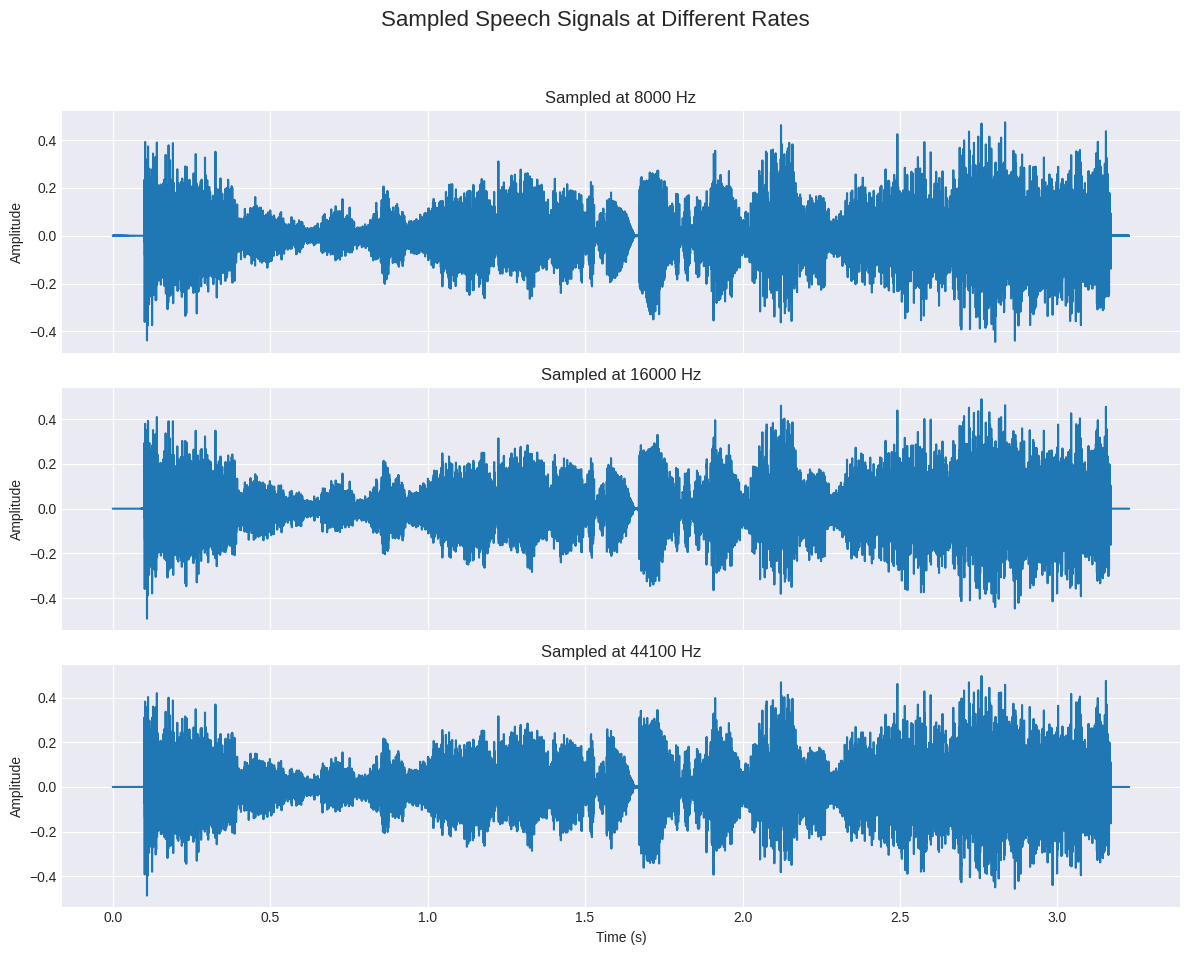


(d, e) Reconstructing signals and calculating MSE:

--- MSE Results ---

Method: zero_order_hold
  Sampling Rate: 8000 Hz -> MSE: 0.002928
  Sampling Rate: 16000 Hz -> MSE: 0.000789
  Sampling Rate: 44100 Hz -> MSE: 0.000000

Method: linear_interpolation
  Sampling Rate: 8000 Hz -> MSE: 0.002186
  Sampling Rate: 16000 Hz -> MSE: 0.000542
  Sampling Rate: 44100 Hz -> MSE: 0.000000

--- Inference for Question 1 ---

        The results demonstrate a core principle of digital signal processing: the sampling rate directly impacts the quality of the reconstructed signal.
        1.  **Higher Sampling Rate, Lower Error:** As the sampling rate increases, the Mean Squared Error (MSE) consistently decreases for both reconstruction methods. This is because a higher sampling rate captures more data points from the original signal, preserving more of its high-frequency details.
        2.  **Reconstruction Method:** Linear interpolation generally yields a lower MSE than the zero-order hold. The z

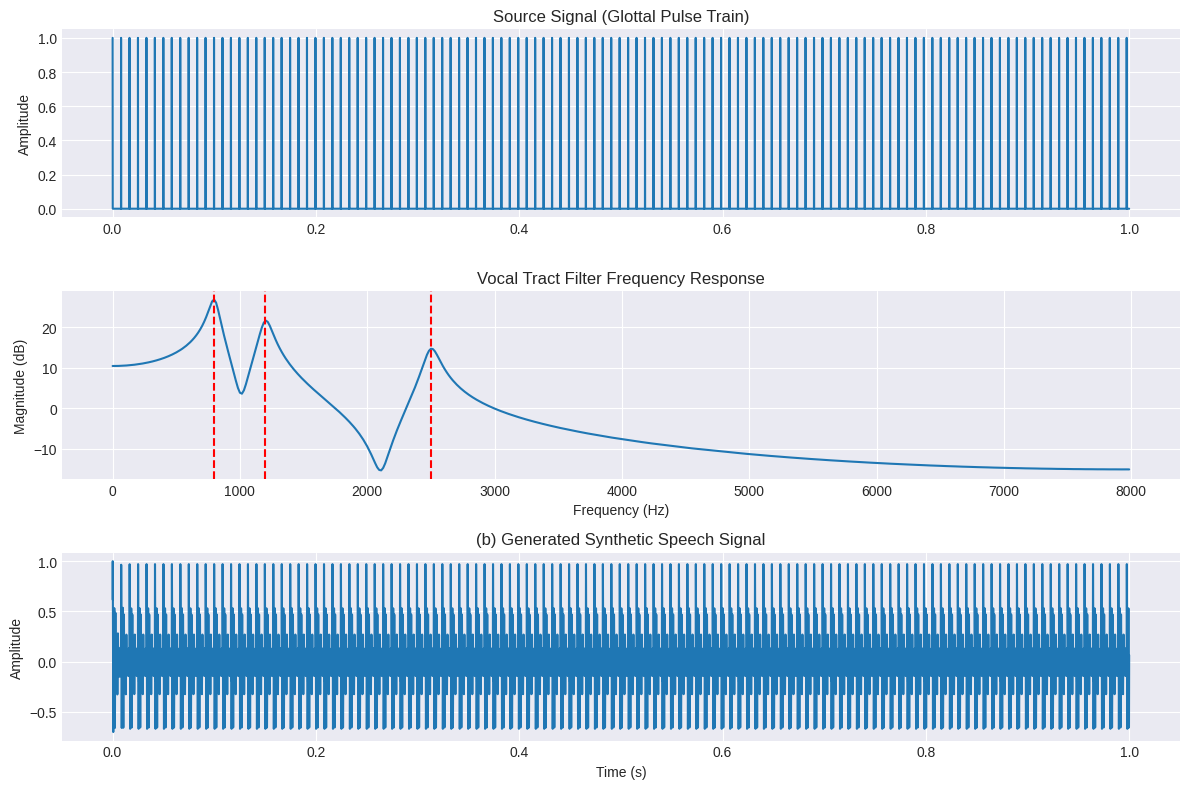


(c, d, e) Sampling, Reconstructing, and Calculating MSE for Synthetic Speech:

--- Synthetic Speech MSE Results ---
  Sampling Rate: 8000 Hz -> MSE: 0.005287
  Sampling Rate: 16000 Hz -> MSE: 0.000000

--- Inference for Question 2 ---

        1.  **Source-Filter Model:** This model effectively separates the two main components of speech production: the source (vocal cord vibration, creating pitch) and the filter (the vocal tract, shaping the sound to form vowels and consonants). The plots clearly show how a simple, periodic pulse train (the source) is transformed by the filter into a complex, speech-like waveform.
        2.  **Impact of Sampling:** Sampling the synthetic speech signal demonstrates the same principles as with the real speech signal. When the signal is downsampled (e.g., to 8kHz from its original 16kHz), information is lost. This loss is quantified by the increase in Mean Squared Error (MSE) after reconstruction.
        3.  **Reconstruction Quality:** Reconstructing 

In [ ]:
# 2. Only run the analysis if a valid file path was provided.
if speech_file_path:
    # --- Question 1: Sampling and Reconstruction of Speech ---
    print("\n--- Running Speech Question 1: Sampling and Reconstruction ---")

    try:
        # (a) Load and plot the original speech signal from the user's file
        original_sr, original_speech = wavfile.read(speech_file_path)
        # Normalize to float between -1 and 1 for processing
        if original_speech.dtype == np.int16:
            original_speech = original_speech.astype(np.float32) / np.iinfo(np.int16).max
        elif original_speech.dtype == np.int32:
            original_speech = original_speech.astype(np.float32) / np.iinfo(np.int32).max

        # If the audio is stereo, convert it to mono by averaging channels
        if original_speech.ndim > 1:
            original_speech = original_speech.mean(axis=1)

        time = np.linspace(0., len(original_speech) / original_sr, len(original_speech))

        plt.figure(figsize=(12, 4))
        plt.plot(time, original_speech)
        plt.title('(a) Original Speech Signal from Your File')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()

        # (b) Sample the speech signal at different rates
        target_rates = [8000, 16000, 44100]
        # We only process rates up to the original sampling rate
        valid_target_rates = [r for r in target_rates if r <= original_sr]
        if original_sr not in valid_target_rates:
            valid_target_rates.append(original_sr)
        valid_target_rates.sort()

        sampled_signals = {}

        print("\n(b, c) Resampling speech signal and plotting:")
        fig_q1, axs_q1 = plt.subplots(len(valid_target_rates), 1, figsize=(12, 10), sharex=True)
        if len(valid_target_rates) == 1: # Handle case of single plot
            axs_q1 = [axs_q1]
        fig_q1.suptitle('Sampled Speech Signals at Different Rates', fontsize=16)

        for i, rate in enumerate(valid_target_rates):
            num_samples = int(len(original_speech) * rate / original_sr)
            resampled_signal = resample(original_speech, num_samples)
            sampled_signals[rate] = resampled_signal

            # (c) Plot the sampled signals
            time_resampled = np.linspace(0., len(resampled_signal) / rate, len(resampled_signal))
            axs_q1[i].plot(time_resampled, resampled_signal)
            axs_q1[i].set_title(f'Sampled at {rate} Hz')
            axs_q1[i].set_ylabel('Amplitude')
            if i == len(valid_target_rates) - 1:
                axs_q1[i].set_xlabel('Time (s)')
            axs_q1[i].grid(True)

        fig_q1.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # (d) Reconstruct the signals and (e) Calculate MSE
        print("\n(d, e) Reconstructing signals and calculating MSE:")
        mse_results = {"zero_order_hold": {}, "linear_interpolation": {}}

        for rate, sampled_signal in sampled_signals.items():
            time_sampled = np.linspace(0, len(original_speech) / original_sr, len(sampled_signal))
            time_original = np.linspace(0, len(original_speech) / original_sr, len(original_speech))

            # (i) Zero-order hold reconstruction
            f_zoh = interp1d(time_sampled, sampled_signal, kind='nearest', fill_value='extrapolate')
            reconstructed_zoh = f_zoh(time_original)
            mse_results["zero_order_hold"][rate] = mean_squared_error(original_speech, reconstructed_zoh)

            # (ii) Linear interpolation reconstruction
            f_linear = interp1d(time_sampled, sampled_signal, kind='linear', fill_value='extrapolate')
            reconstructed_linear = f_linear(time_original)
            mse_results["linear_interpolation"][rate] = mean_squared_error(original_speech, reconstructed_linear)

        print("\n--- MSE Results ---")
        for method, results in mse_results.items():
            print(f"\nMethod: {method}")
            for rate, mse in sorted(results.items()):
                print(f"  Sampling Rate: {rate} Hz -> MSE: {mse:.6f}")

        print("\n--- Inference for Question 1 ---")
        print("""
        The results demonstrate a core principle of digital signal processing: the sampling rate directly impacts the quality of the reconstructed signal.
        1.  **Higher Sampling Rate, Lower Error:** As the sampling rate increases, the Mean Squared Error (MSE) consistently decreases for both reconstruction methods. This is because a higher sampling rate captures more data points from the original signal, preserving more of its high-frequency details.
        2.  **Reconstruction Method:** Linear interpolation generally yields a lower MSE than the zero-order hold. The zero-order hold creates a 'blocky' or 'staircase' approximation, while linear interpolation provides a smoother, more accurate representation by connecting sample points with straight lines.
        3.  **Quality Impact:** A low sampling rate (like 8kHz, common for telephony) results in a loss of fidelity, making the speech sound muffled as higher frequencies are lost. A high sampling rate (like 44.1kHz, standard for CDs) produces a reconstructed signal that is nearly indistinguishable from the original, resulting in high-quality audio.
        """)

    except Exception as e:
        print(f"\nAn error occurred during Question 1 processing: {e}")


    # --- Question 2: Source-Filter Model ---
    print("\n\n--- Running Speech Question 2: Source-Filter Model ---")
    try:
        # (a) Generate a synthetic speech signal
        sr_synth = 16000
        duration_synth = 1.0
        n_samples = int(sr_synth * duration_synth)
        time_synth = np.linspace(0, duration_synth, n_samples)

        # (i) Create a source signal (glottal pulse train for a voiced sound)
        f0 = 120  # Fundamental frequency (pitch) of 120 Hz
        pulse_period = int(sr_synth / f0)
        source_signal = np.zeros(n_samples)
        for i in range(0, n_samples, pulse_period):
            source_signal[i] = 1.0

        # (ii) Apply a filter to model the vocal tract (Formants for /a/ vowel)
        formants = [800, 1200, 2500] # Example formants for vowel 'ah'
        bandwidths = [80, 100, 120]

        vocal_tract_filter = np.zeros(512)
        for f, bw in zip(formants, bandwidths):
            w = 2 * np.pi * f / sr_synth
            pole_mag = np.exp(-np.pi * bw / sr_synth)
            a = [1, -2 * pole_mag * np.cos(w), pole_mag**2]
            b = [1]
            impulse = np.zeros(512)
            impulse[0] = 1.0
            response = lfilter(b, a, impulse)
            vocal_tract_filter += response
        vocal_tract_filter /= np.max(np.abs(vocal_tract_filter))

        synthetic_speech = lfilter(vocal_tract_filter, 1, source_signal)
        synthetic_speech /= np.max(np.abs(synthetic_speech))

        # (b) Plot generated speech and filter effect
        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(time_synth, source_signal)
        plt.title('Source Signal (Glottal Pulse Train)')
        plt.ylabel('Amplitude')
        plt.grid(True)

        plt.subplot(3, 1, 2)
        w, h = freqz(vocal_tract_filter)
        plt.plot((w / np.pi) * (sr_synth / 2), 20 * np.log10(abs(h)))
        plt.title('Vocal Tract Filter Frequency Response')
        for f in formants:
            plt.axvline(f, color='r', linestyle='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)

        plt.subplot(3, 1, 3)
        plt.plot(time_synth, synthetic_speech)
        plt.title('(b) Generated Synthetic Speech Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # (c, d, e) - Sample, Reconstruct, and Compute MSE for the synthetic signal
        print("\n(c, d, e) Sampling, Reconstructing, and Calculating MSE for Synthetic Speech:")
        target_rates_synth = [8000, 16000] # Below and at the original rate
        mse_results_synth = {"linear_interpolation": {}}

        for rate in target_rates_synth:
            num_samples_synth = int(len(synthetic_speech) * rate / sr_synth)
            resampled_synth = resample(synthetic_speech, num_samples_synth)

            time_resampled_synth = np.linspace(0, duration_synth, len(resampled_synth))
            f_linear_synth = interp1d(time_resampled_synth, resampled_synth, kind='linear', fill_value='extrapolate')
            reconstructed_synth = f_linear_synth(time_synth)

            mse_results_synth["linear_interpolation"][rate] = mean_squared_error(synthetic_speech, reconstructed_synth)

        print("\n--- Synthetic Speech MSE Results ---")
        for rate, mse in mse_results_synth["linear_interpolation"].items():
            print(f"  Sampling Rate: {rate} Hz -> MSE: {mse:.6f}")


        print("\n--- Inference for Question 2 ---")
        print("""
        1.  **Source-Filter Model:** This model effectively separates the two main components of speech production: the source (vocal cord vibration, creating pitch) and the filter (the vocal tract, shaping the sound to form vowels and consonants). The plots clearly show how a simple, periodic pulse train (the source) is transformed by the filter into a complex, speech-like waveform.
        2.  **Impact of Sampling:** Sampling the synthetic speech signal demonstrates the same principles as with the real speech signal. When the signal is downsampled (e.g., to 8kHz from its original 16kHz), information is lost. This loss is quantified by the increase in Mean Squared Error (MSE) after reconstruction.
        3.  **Reconstruction Quality:** Reconstructing the downsampled signal back to its original sampling rate does not recover the lost information. Interpolation can't recreate high-frequency details that were removed during downsampling, highlighting that this is a lossy process if the rate is not high enough.
        """)

    except Exception as e:
        print(f"\nAn error occurred during Question 2 processing: {e}")

    print("\nAll speech processing tasks are complete.")

else:
    print("\nProgram exited because no audio file was provided.")